<a href="https://colab.research.google.com/github/Incognito005/KNN_DuDoan_KQBD/blob/main/KNN_D%E1%BB%B1_%C4%91o%C3%A1n_KQBD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [139]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

warnings.filterwarnings('ignore')

In [141]:
# CÁC HÀM FEATURE ENGINEERING

In [142]:
def preprocess_data(df):
    """Tiền xử lý cơ bản: Sắp xếp theo ngày, tạo cột chỉ báo thắng/thua/hòa, và mã hóa Target."""

    # Chuyển đổi MatchDate sang datetime và sắp xếp theo thứ tự thời gian
    df['MatchDate'] = pd.to_datetime(df['MatchDate'], dayfirst=False)
    df = df.sort_values(by='MatchDate').reset_index(drop=True)

    # Tạo các cột chỉ báo Thắng/Hòa/Thua (dạng 0/1)
    df['HomeWin'] = (df['FullTimeResult'] == 'H').astype(int)
    df['HomeDraw'] = (df['FullTimeResult'] == 'D').astype(int)
    df['HomeLoss'] = (df['FullTimeResult'] == 'A').astype(int)
    df['AwayWin'] = (df['FullTimeResult'] == 'A').astype(int)
    df['AwayDraw'] = (df['FullTimeResult'] == 'D').astype(int)
    df['AwayLoss'] = (df['FullTimeResult'] == 'H').astype(int)

    # Mã hóa biến mục tiêu (Label): H -> 1, D -> 0, A -> 2
    label_mapping = {'H': 1, 'D': 0, 'A': 2}
    df['Target'] = df['FullTimeResult'].map(label_mapping)

    return df

In [143]:
def calculate_rolling_features(df, window=5):
    """Tính toán các features lịch sử lăn (rolling features) 5 trận gần nhất cho mỗi đội."""

    # Tạo DataFrame chung cho Hiệu suất của TẤT CẢ các trận đấu từ góc nhìn của MỘT ĐỘI
    team_home = df[['MatchDate', 'HomeTeam', 'HomeWin', 'HomeDraw', 'FullTimeHomeGoals', 'FullTimeAwayGoals', 'HomeShotsOnTarget', 'AwayShotsOnTarget']].copy()
    team_home.columns = ['MatchDate', 'Team', 'Win', 'Draw', 'GoalsFor', 'GoalsAgainst', 'ShotsOnTargetFor', 'ShotsOnTargetAgainst']
    team_home['IsHome'] = 1

    team_away = df[['MatchDate', 'AwayTeam', 'AwayWin', 'AwayDraw', 'FullTimeAwayGoals', 'FullTimeHomeGoals', 'AwayShotsOnTarget', 'HomeShotsOnTarget']].copy()
    team_away.columns = ['MatchDate', 'Team', 'Win', 'Draw', 'GoalsFor', 'GoalsAgainst', 'ShotsOnTargetFor', 'ShotsOnTargetAgainst']
    team_away['IsHome'] = 0

    team_performance = pd.concat([team_home, team_away], ignore_index=True)
    team_performance = team_performance.sort_values(by=['MatchDate', 'Team'])

    def calculate_stats(group):
        # shift(1) RẤT QUAN TRỌNG: Đảm bảo không sử dụng kết quả của trận đấu hiện tại
        shifted_group = group.sort_values(by='MatchDate').shift(1)
        stats = shifted_group.rolling(window=window, min_periods=1)

        # 1. Tính toán các chỉ số chung (Rolling 5)
        group[f'WinRate{window}'] = stats['Win'].mean()
        group[f'DrawRate{window}'] = stats['Draw'].mean()
        group[f'AvgGoalsFor{window}'] = stats['GoalsFor'].mean()
        group[f'AvgGoalsAgainst{window}'] = stats['GoalsAgainst'].mean()
        group[f'AvgShotsOnTargetFor{window}'] = stats['ShotsOnTargetFor'].mean()
        group[f'AvgShotsOnTargetAgainst{window}'] = stats['ShotsOnTargetAgainst'].mean()

        # 2. Tỷ lệ thắng Sân Nhà/Sân Khách (chỉ xét Home/Away Games trước đó)
        shifted_group['HomeGameWin'] = shifted_group['Win'].where(shifted_group['IsHome'] == 1)
        shifted_group['AwayGameWin'] = shifted_group['Win'].where(shifted_group['IsHome'] == 0)

        full_home_rate = shifted_group['HomeGameWin'].rolling(window=window, min_periods=1).mean()
        full_away_rate = shifted_group['AwayGameWin'].rolling(window=window, min_periods=1).mean()

        # Gán kết quả rolling rate vào vị trí tương ứng
        group[f'HomeHomeWinRate{window}'] = np.where(group['IsHome'] == 1, full_home_rate, np.nan)
        group[f'AwayAwayWinRate{window}'] = np.where(group['IsHome'] == 0, full_away_rate, np.nan)

        return group

    # Áp dụng hàm tính toán cho mỗi đội
    team_performance = team_performance.groupby('Team', group_keys=False).apply(calculate_stats).reset_index(drop=True)

    # Lấy các cột tính toán được và Merge trở lại DataFrame gốc (df)
    cols_to_merge = [col for col in team_performance.columns if any(s in col for s in ['Rate', 'Avg'])]
    home_features = team_performance[team_performance['IsHome'] == 1].rename(
        columns={c: 'Home_' + c for c in cols_to_merge}
    )[['MatchDate', 'Team'] + ['Home_' + c for c in cols_to_merge]]
    df = pd.merge(df, home_features.rename(columns={'Team': 'HomeTeam'}), on=['MatchDate', 'HomeTeam'], how='left')

    away_features = team_performance[team_performance['IsHome'] == 0].rename(
        columns={c: 'Away_' + c for c in cols_to_merge}
    )[['MatchDate', 'Team'] + ['Away_' + c for c in cols_to_merge]]
    df = pd.merge(df, away_features.rename(columns={'Team': 'AwayTeam'}), on=['MatchDate', 'AwayTeam'], how='left')

    # Đổi tên cột cho khớp với yêu cầu
    df.rename(columns={
        'Home_WinRate5': 'HomeWinRate5', 'Away_WinRate5': 'AwayWinRate5',
        'Home_DrawRate5': 'HomeDrawRate5', 'Away_DrawRate5': 'AwayDrawRate5',
        'Home_AvgGoalsFor5': 'HomeAvgGoals5', 'Away_AvgGoalsFor5': 'AwayAvgGoals5',
        'Home_AvgGoalsAgainst5': 'HomeAvgGoalsConceded5', 'Away_AvgGoalsAgainst5': 'AwayAvgGoalsConceded5',
        'Home_AvgShotsOnTargetFor5': 'HomeAvgShotOnTarget5', 'Away_AvgShotsOnTargetFor5': 'AwayAvgShotOnTarget5',
        'Home_AvgShotsOnTargetAgainst5': 'HomeAvgShotsConceded5', 'Away_AvgShotsOnTargetAgainst5': 'AwayAvgShotsConceded5',
        'Home_HomeHomeWinRate5': 'HomeHomeWinRate5',
        'Away_AwayAwayWinRate5': 'AwayAwayWinRate5',
    }, inplace=True)
    return df

In [144]:
def calculate_h2h_features(df, window=5):
    """Tính toán các features Đối đầu (Head-to-Head) 5 trận gần nhất."""
    df = df.copy()
    df = df.sort_values(by='MatchDate').reset_index(drop=True)

    df['Head2Head_HomeWinRate5'] = np.nan
    df['Head2Head_DrawRate5'] = np.nan
    df['Head2Head_AwayWinRate5'] = np.nan

    for idx, row in df.iterrows():
        team1, team2 = row['HomeTeam'], row['AwayTeam']
        match_date = row['MatchDate']

        # Lọc các trận đối đầu TRƯỚC trận đấu hiện tại (5 trận gần nhất)
        past_matches = df[
            (((df['HomeTeam'] == team1) & (df['AwayTeam'] == team2)) |
             ((df['HomeTeam'] == team2) & (df['AwayTeam'] == team1))) &
            (df['MatchDate'] < match_date)
        ].sort_values(by='MatchDate', ascending=False).head(window)

        total = len(past_matches)

        if total == 0:
            continue

        home_wins = draws = away_wins = 0

        for _, match in past_matches.iterrows():
            if match['FullTimeResult'] == 'D':
                draws += 1
            # team1 (đội nhà của trận hiện tại) thắng
            elif (match['HomeTeam'] == team1 and match['FullTimeResult'] == 'H') or \
                 (match['AwayTeam'] == team1 and match['FullTimeResult'] == 'A'):
                home_wins += 1
            # team2 (đội khách của trận hiện tại) thắng
            else:
                away_wins += 1

        df.loc[idx, 'Head2Head_HomeWinRate5'] = home_wins / total
        df.loc[idx, 'Head2Head_DrawRate5'] = draws / total
        df.loc[idx, 'Head2Head_AwayWinRate5'] = away_wins / total

    return df

In [145]:
def calculate_league_averages(df):
    """Tính trung bình giải đấu để điền vào các giá trị bị thiếu (NaN)."""
    league_avg = {
        'win_rate': 0.33,
        'draw_rate': 0.27,
        'goals': df[['FullTimeHomeGoals', 'FullTimeAwayGoals']].mean().mean(),
        'shots_on_target': df[['HomeShotsOnTarget', 'AwayShotsOnTarget']].mean().mean()
    }
    return league_avg

In [146]:
# TẢI DỮ LIỆU & FEATURE ENGINEERING

In [147]:
# Tải dữ liệu
print("\nĐang tải dữ liệu...")
df = pd.read_csv('/content/drive/My Drive/Data_ML/epl_24-25.csv')
print(f"Đã tải thành công {len(df)} trận đấu")


Đang tải dữ liệu...
Đã tải thành công 730 trận đấu


In [148]:
# Feature Engineering
print("\nĐang tạo Feature Engineering...")
df = preprocess_data(df)
df = calculate_rolling_features(df, window=5)
df = calculate_h2h_features(df, window=5)
print("Đã hoàn thành tạo Features")


Đang tạo Feature Engineering...
Đã hoàn thành tạo Features


In [149]:
# Định nghĩa Features
feature_cols = [
    'HomeWinRate5', 'AwayWinRate5', 'HomeDrawRate5', 'AwayDrawRate5',
    'HomeAvgGoals5', 'AwayAvgGoals5', 'HomeAvgGoalsConceded5', 'AwayAvgGoalsConceded5',
    'HomeHomeWinRate5', 'AwayAwayWinRate5',
    'HomeAvgShotOnTarget5', 'AwayAvgShotOnTarget5',
    'HomeAvgShotsConceded5', 'AwayAvgShotsConceded5',
    'Head2Head_HomeWinRate5', 'Head2Head_DrawRate5', 'Head2Head_AwayWinRate5'
]

X = df[feature_cols]
y = df['Target']

In [150]:
# Xử lý giá trị thiếu (NaN) bằng trung bình giải đấu (Impute)
league_avg = calculate_league_averages(df)
impute_values = {
    'HomeWinRate5': league_avg['win_rate'], 'AwayWinRate5': league_avg['win_rate'],
    'HomeDrawRate5': league_avg['draw_rate'], 'AwayDrawRate5': league_avg['draw_rate'],
    'HomeAvgGoals5': league_avg['goals'], 'AwayAvgGoals5': league_avg['goals'],
    'HomeAvgGoalsConceded5': league_avg['goals'], 'AwayAvgGoalsConceded5': league_avg['goals'],
    'HomeHomeWinRate5': league_avg['win_rate'], 'AwayAwayWinRate5': league_avg['win_rate'],
    'HomeAvgShotOnTarget5': league_avg['shots_on_target'], 'AwayAvgShotOnTarget5': league_avg['shots_on_target'],
    'HomeAvgShotsConceded5': league_avg['shots_on_target'], 'AwayAvgShotsConceded5': league_avg['shots_on_target'],
    'Head2Head_HomeWinRate5': league_avg['win_rate'],
    'Head2Head_DrawRate5': league_avg['draw_rate'],
    'Head2Head_AwayWinRate5': league_avg['win_rate']
}
X = X.fillna(impute_values)

In [151]:
# Chia dữ liệu theo chuỗi thời gian (Time-series split 80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"\nKích thước tập huấn luyện (Train): {len(X_train)}, Kích thước tập kiểm tra (Test): {len(X_test)}")


Kích thước tập huấn luyện (Train): 584, Kích thước tập kiểm tra (Test): 146


In [152]:
# Chuẩn hóa dữ liệu (Scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Đã hoàn thành chuẩn hóa dữ liệu.")

Đã hoàn thành chuẩn hóa dữ liệu.


In [153]:
# TÌM K TỐI ƯU & HUẤN LUYỆN MÔ HÌNH

In [154]:
# 1. Cấu hình Grid Search mở rộng
# Khảo sát K từ 1 đến 61 (số lẻ)
# Khảo sát 3 độ đo: Manhattan (p=1), Euclidean (p=2), Chebyshev
# Sử dụng weights='distance' như phân tích trong báo cáo
param_grid = {
    'n_neighbors': list(range(1, 62, 2)),
    'weights': ['distance'],
    'metric': ['manhattan', 'euclidean', 'chebyshev']
}

tscv = TimeSeriesSplit(n_splits=5)
print("Đang chạy Grid Search (so sánh Manhattan, Euclidean, Chebyshev)...")
# return_train_score=True để vẽ biểu đồ Train vs Test
knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=tscv,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
)

knn_grid.fit(X_train_scaled, y_train)

# Lấy kết quả để phân tích
results = pd.DataFrame(knn_grid.cv_results_)
best_params = knn_grid.best_params_
best_score = knn_grid.best_score_

print(f"\n>>> KẾT QUẢ TỐI ƯU TÌM ĐƯỢC:")
print(f" - Độ đo (Metric): {best_params['metric']}")
print(f" - Số láng giềng (K): {best_params['n_neighbors']}")
print(f" - Độ chính xác CV trung bình: {best_score:.4f}")

Đang chạy Grid Search (so sánh Manhattan, Euclidean, Chebyshev)...

>>> KẾT QUẢ TỐI ƯU TÌM ĐƯỢC:
 - Độ đo (Metric): chebyshev
 - Số láng giềng (K): 19
 - Độ chính xác CV trung bình: 0.4990


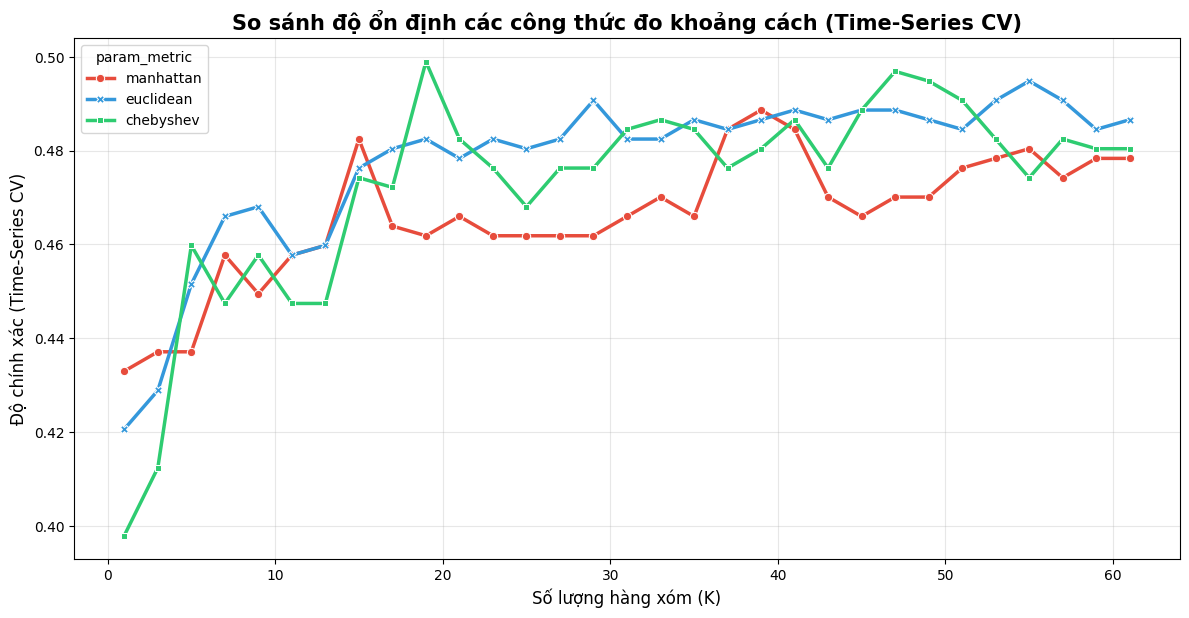

In [155]:
# SO SÁNH 3 ĐỘ ĐO
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results,
    x='param_n_neighbors',
    y='mean_test_score',
    hue='param_metric',
    style='param_metric',
    markers=True,
    dashes=False,
    palette={'manhattan': '#e74c3c', 'euclidean': '#3498db', 'chebyshev': '#2ecc71'},
    linewidth=2.5  # ← THÊM: Làm đường vẽ dày hơn
)
plt.xlabel('Số lượng hàng xóm (K)', fontsize=12)
plt.ylabel('Độ chính xác (Time-Series CV)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()  # Tự động căn chỉnh layout
plt.title('So sánh độ ổn định các công thức đo khoảng cách (Time-Series CV)', fontsize=15, fontweight='bold')
plt.show()




<Figure size 1200x600 with 0 Axes>

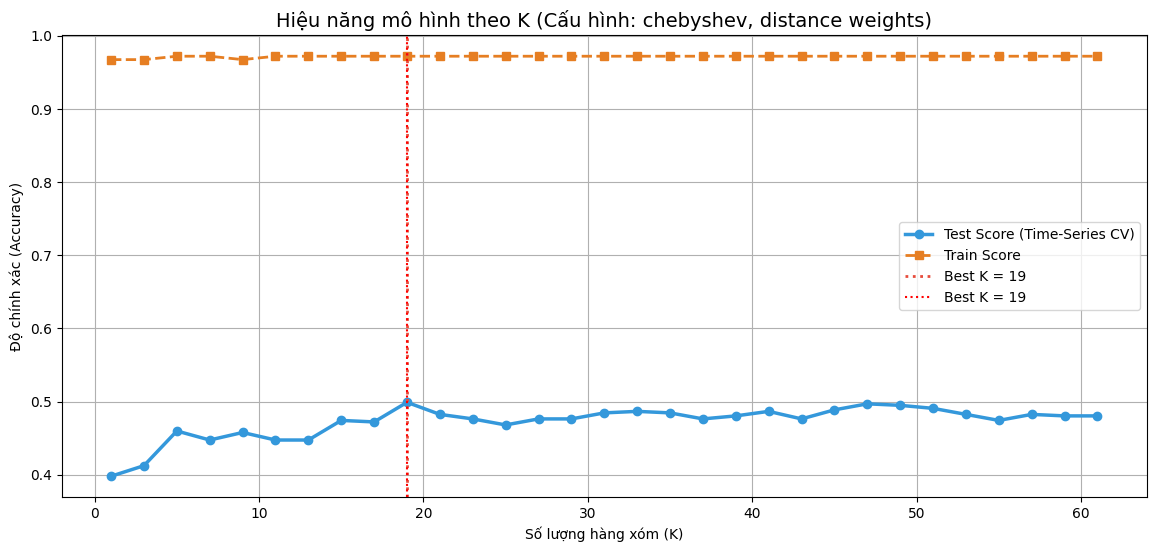


--- ĐÁNH GIÁ TRÊN TẬP TEST ---
Độ chính xác Test Set: 0.5205 (52.05%)

Báo cáo phân loại:
              precision    recall  f1-score   support

    Draw (0)       0.38      0.28      0.32        29
 HomeWin (1)       0.55      0.73      0.63        64
 AwayWin (2)       0.54      0.40      0.46        53

    accuracy                           0.52       146
   macro avg       0.49      0.47      0.47       146
weighted avg       0.51      0.52      0.50       146



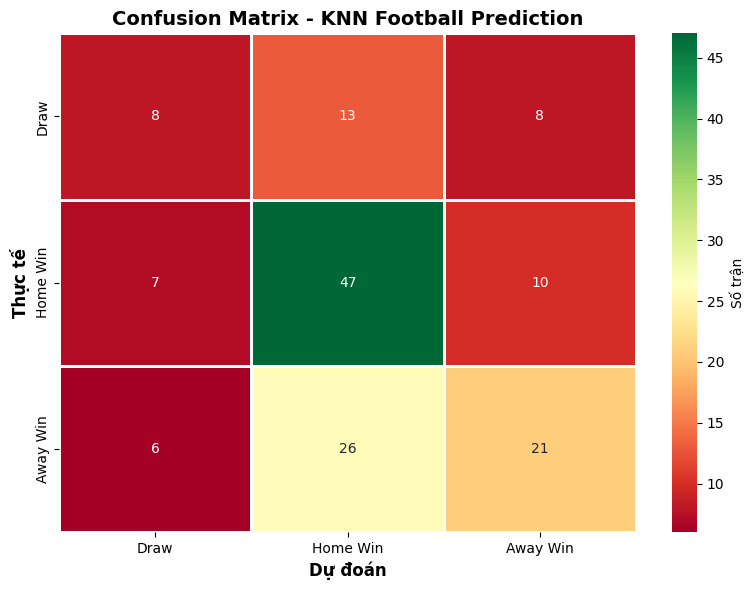

In [156]:
# PHÂN TÍCH HỘI TỤ CỦA METRIC TỐT NHẤT
# Lọc lấy dữ liệu của độ đo tốt nhất (thường là manhattan hoặc euclidean)
best_metric = best_params['metric']
mask = results['param_metric'] == best_metric
best_metric_data = results[mask]

plt.figure(figsize=(12, 6))
plt.figure(figsize=(14, 6))
plt.plot(
    best_metric_data['param_n_neighbors'],
    best_metric_data['mean_test_score'],
    marker='o', label='Test Score (Time-Series CV)', color='#3498db', linewidth=2.5
)
plt.plot(
    best_metric_data['param_n_neighbors'],
    best_metric_data['mean_train_score'],
    marker='s',
    linestyle='--', label='Train Score', color='#e67e22', linewidth=2
)
plt.axvline(
    x=best_params['n_neighbors'],
    color='#e74c3c',
    linestyle=':',
    linewidth=2,
    label=f'Best K = {best_params["n_neighbors"]}'
)
# Đường kẻ dọc đánh dấu K tối ưu
plt.axvline(x=best_params['n_neighbors'], color='red', linestyle=':', label=f'Best K = {best_params["n_neighbors"]}')

plt.title(f'Hiệu năng mô hình theo K (Cấu hình: {best_metric}, distance weights)', fontsize=14)
plt.xlabel('Số lượng hàng xóm (K)')
plt.ylabel('Độ chính xác (Accuracy)')
plt.legend()
plt.grid(True)
plt.show()

# HUẤN LUYỆN MÔ HÌNH CUỐI CÙNG & ĐÁNH GIÁ (TEST SET)

print(f"\n--- ĐÁNH GIÁ TRÊN TẬP TEST ---")
knn_final = knn_grid.best_estimator_
knn_final.fit(X_train_scaled, y_train)

y_pred_knn = knn_final.predict(X_test_scaled)
acc_knn = accuracy_score(y_test, y_pred_knn)

print(f"Độ chính xác Test Set: {acc_knn:.4f} ({acc_knn*100:.2f}%)")
print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred_knn, target_names=['Draw (0)', 'HomeWin (1)', 'AwayWin (2)']))

# Ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn',
            cbar_kws={'label': 'Số trận'},
            xticklabels=['Draw', 'Home Win', 'Away Win'],
            yticklabels=['Draw', 'Home Win', 'Away Win'],
            linewidths=2, linecolor='white')
plt.ylabel('Thực tế', fontsize=12, fontweight='bold')
plt.xlabel('Dự đoán', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - KNN Football Prediction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()